In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
from collections import defaultdict
import random
import numpy as np
import torch

In [3]:
ROOT = "/users/kcochran/projects/domain_adaptation_nosexchr/"

SPECIES = ["mm10", "hg38"]
fancy_species_names = {"mm10" : "Mouse", "hg38" : "Human"}
TFS = ["CTCF", "CEBPA", "Hnf4a", "RXRA"]
fancy_tf_names = {"CTCF" : "CTCF", "CEBPA" : "CEBPA",
                  "Hnf4a" : "HNF4A", "RXRA" : "RXRA"}

MAX_JITTER = 200
INPUT_SEQ_LEN = 2114
OUTPUT_PROF_LEN = 1000

In [4]:
GENOMES = { "mm10" : "/users/kcochran/genomes/mm10_no_alt_analysis_set_ENCODE.fasta",
            "hg38" : "/users/kcochran/genomes/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta" }

PEAKS_DIR = ROOT + "/data/"
BIGWIGS_DIR = ROOT + "/profile_model_data/"
MODEL_SAVE_DIR = ROOT + "/models/profile_models/"


def get_filepaths(train_val_test, species, tf, unbound = False):
    assert train_val_test in ["train", "val", "test"], train_val_test
    if unbound:
        assert train_val_test == "train"
    assert species in SPECIES, species
    assert tf in TFS, tf
    
    filepaths = dict()
    filepaths["pos_bw"] = BIGWIGS_DIR + species + "/" + tf + "/all_reps.pos.bigWig"
    filepaths["neg_bw"] = BIGWIGS_DIR + species + "/" + tf + "/all_reps.neg.bigWig"
    filepaths["pos_control_bw"] = BIGWIGS_DIR + species + "/" + tf + "_control/all_reps.pos.bigWig"
    filepaths["neg_control_bw"] = BIGWIGS_DIR + species + "/" + tf + "_control/all_reps.neg.bigWig"
    filepaths["genome_file"] = GENOMES[species]
    
    if train_val_test == "train":
        if unbound:
            filepaths["peakfile"] = PEAKS_DIR + species + "/" + tf + "/filtered_peaks_chr3toY_gc_matched_neg.bed"
        else:
            filepaths["peakfile"] = PEAKS_DIR + species + "/" + tf + "/filtered_peaks_chr3toY.bed"
    elif train_val_test == "val":
        filepaths["peakfile"] = PEAKS_DIR + species + "/" + tf + "/filtered_peaks_chr1.bed"
    else:
        #print("Loading test set.")
        filepaths["peakfile"] = PEAKS_DIR + species + "/" + tf + "/filtered_peaks_chr2.bed"

    return filepaths

In [5]:
from torch.utils.data import ConcatDataset
from data_transforms import *
from generators import *
from model_arch import *

In [6]:
MODEL_SAVE_DIR = ROOT + "models/profile_models/"


def load_models(tf):
    models = dict()
    for train_species in SPECIES:
        model_file = MODEL_SAVE_DIR + train_species + "-trained/" + tf + "/" + "bestprof.model"
        models[train_species] = torch.load(model_file)
        
    return models


def get_generator_and_data_loader(train_species, tf):
    generator = Generator(get_filepaths("test", train_species, tf),
                          seq_len = INPUT_SEQ_LEN,
                          profile_len = OUTPUT_PROF_LEN,
                          max_jitter = MAX_JITTER,
                          transform = NoJitter(MAX_JITTER,
                                               INPUT_SEQ_LEN,
                                               OUTPUT_PROF_LEN),
                          return_labels = False)
    data_loader = DataLoader(generator, batch_size = 32, shuffle = False)
    return generator, data_loader


def load_data(tf):
    generators = dict()
    data_loaders = dict()
    for train_species in SPECIES:
        generator, data_loader = get_generator_and_data_loader(train_species, tf)
        generators[train_species] = generator
        data_loaders[train_species] = data_loader
    return generators, data_loaders

In [7]:
def predict_profiles(data_loader, model):
    pred_profiles = []

    model.cuda()
    model.eval()
    with torch.no_grad():
        for seq, control_profile, control_logcounts in data_loader:
            seq = seq.cuda()
            control_profile = pad_control_profile(control_profile, model.untrimmed_prof_len).cuda()
            control_logcounts = control_logcounts.cuda()
            pred_profile = model((seq, control_profile, control_logcounts))[0].cpu().detach().numpy()
            pred_profiles.extend(pred_profile)
    model.cpu()
    
    return np.array(pred_profiles).squeeze()


def get_all_pred_profiles(data_loaders, models):
    all_pred_profiles = defaultdict(lambda : dict())
    
    for test_species in SPECIES:
        data_loader = data_loaders[test_species]
        
        for train_species in SPECIES:
            model = models[train_species]
        
            all_pred_profiles[test_species][train_species] = predict_profiles(data_loader, model)
            
    return all_pred_profiles

In [8]:
import matplotlib.pyplot as plt
from scipy.special import softmax


def process_pred_profile_for_plot(true_profile, pred_profile):
    total_counts_in_profile = np.sum(true_profile, axis=-1, keepdims=True)
    
    trimmed_pred_profile = trim_profile_by_len(pred_profile, OUTPUT_PROF_LEN)
    pred_profile_softmax = softmax(trimmed_pred_profile, axis = -1)
    pred_profile_scaled = total_counts_in_profile * pred_profile_softmax
    return pred_profile_scaled

In [15]:
prof_colors = {"CTCF" : ("#44a8ff", "#005cab"),
               "CEBPA" : ("#f8eb2b", "#aba000"),
               "Hnf4a" : ("#f65a47", "#b71b07"),
               "RXRA" : ("#4aeb6d", "#068f24")}

prof_idxs = {"CTCF" : 0, "CEBPA" : 9, "Hnf4a" : 3, "RXRA" : 2}

def plot_prof(profile, axis, label = None, x_axis = False, prof_colors = None, shrink_by = 100):
    x_vals = np.arange(shrink_by, OUTPUT_PROF_LEN - shrink_by)
    y_ax_max = np.max(profile[:, shrink_by : - shrink_by])
    
    if prof_colors is not None:
        axis.plot(x_vals, profile[0, shrink_by : - shrink_by].squeeze(),
                  alpha=0.8, linewidth=0.8, label = "Pos. Strand", c = prof_colors[0])
        axis.plot(x_vals, -1 * profile[1, shrink_by : - shrink_by].squeeze(),
                  alpha=0.8, linewidth=0.8, label = "Neg. Strand", c = prof_colors[1])
    else:
        axis.plot(x_vals, profile[0, shrink_by : - shrink_by].squeeze(),
                  alpha=0.8, linewidth=0.8, label = "Pos. Strand")
        axis.plot(x_vals, -1 * profile[1, shrink_by : - shrink_by].squeeze(),
                  alpha=0.8, linewidth=0.8, label = "Neg. Strand")
    
    axis.set_xlim(shrink_by, OUTPUT_PROF_LEN - shrink_by)
    axis.set_ylim(- y_ax_max, y_ax_max)
    #axes[plot_idxs[0]].set_title("True Profile", horizontalalignment='right', x = 1, y = 0.8)
    
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.label_outer()
    
    if label is not None:
        axis.set_ylabel(label, rotation=0)
        if label.count("\n") == 1:
            axis.yaxis.set_label_coords(-0.07, 0.36)
        else:
            axis.yaxis.set_label_coords(-0.07, 0.19)
    
    axis.set_yticks([])
    axis.spines['left'].set_visible(False)
    
    axis.set_xticks([])
    axis.spines['bottom'].set_visible(False)

    
def plot_profiles_across_species_tfs(save = False):
    for tf in TFS:
        models = load_models(tf)
        generators, data_loaders = load_data(tf)
        pred_profiles = get_all_pred_profiles(data_loaders, models)

        prof_idx = prof_idxs[tf]
        
        fig = plt.figure(figsize=(14, 3))  # 3 = true, pred, other species pred
        gs = fig.add_gridspec(3, 2, hspace=0.01, wspace=0.05)
        axes = gs.subplots()

        for plot_col_idx, test_species in enumerate(SPECIES):

            true_profile = generators[test_species].profiles[prof_idx]
            true_profile = trim_profile_by_len(true_profile, OUTPUT_PROF_LEN)

            if plot_col_idx == 0:
                plot_prof(true_profile, axes[0, plot_col_idx],
                          label = "True\nProfile", prof_colors = prof_colors[tf])
                

                    
            else:
                plot_prof(true_profile, axes[0, plot_col_idx],
                          prof_colors = prof_colors[tf])

            if tf == TFS[0]:
                axes[0, plot_col_idx].set_title(fancy_species_names[test_species] + " Peaks",
                                                fontsize=14, y = 1.2)


            for pred_idx, train_species in enumerate(SPECIES):
                pred_profile = pred_profiles[test_species][train_species][prof_idx]
                pred_profile = process_pred_profile_for_plot(true_profile, pred_profile)

                if plot_col_idx == 0:
                    plot_prof(pred_profile, axes[pred_idx + 1, plot_col_idx],
                              label = fancy_species_names[train_species] + "\nModel\nPrediction",
                              x_axis = train_species == SPECIES[-1],
                              prof_colors = prof_colors[tf])
                    
                    if pred_idx == 0:  # middle plot
                        # add the TF name label to the far left of the plot
                        ax2 = axes[pred_idx + 1, plot_col_idx].twinx()
                        ax2.spines["left"].set_position(("axes", 0 - 0.15))
                        ax2.spines["left"].set_visible(False)
                        ax2.spines['right'].set_visible(False)
                        ax2.spines['top'].set_visible(False)
                        ax2.spines['bottom'].set_visible(False)
                        ax2.yaxis.set_label_position('left')
                        ax2.yaxis.set_ticks_position('none')
                        ax2.set_yticklabels([])
                        ax2.set_ylabel(fancy_tf_names[tf], fontsize = 16)
                else:
                    plot_prof(pred_profile, axes[pred_idx + 1, plot_col_idx],
                              x_axis = train_species == SPECIES[-1],
                              prof_colors = prof_colors[tf])
                    
        fig.tight_layout()
        
        if save:
            plt.savefig(ROOT + "plots/profile_pred_examples_" + tf + ".png",
                    bbox_inches='tight', pad_inches = 0, dpi = 300)
            plt.savefig(ROOT + "plots/profile_pred_examples_" + tf + ".pdf",
                    bbox_inches='tight', pad_inches = 0)
            

        plt.show()

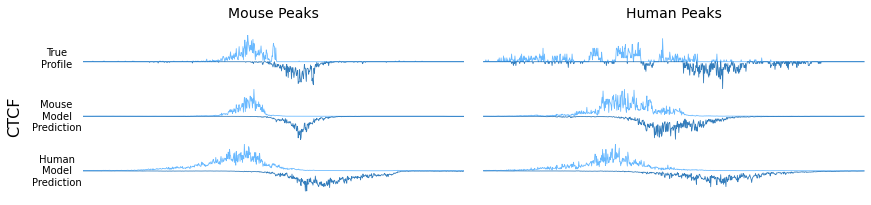

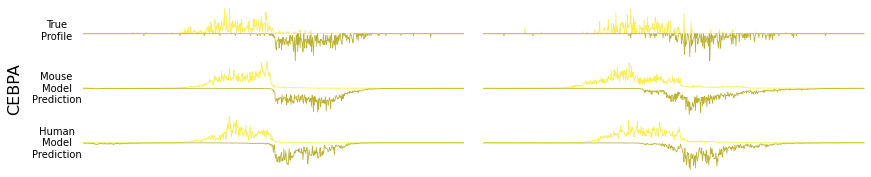

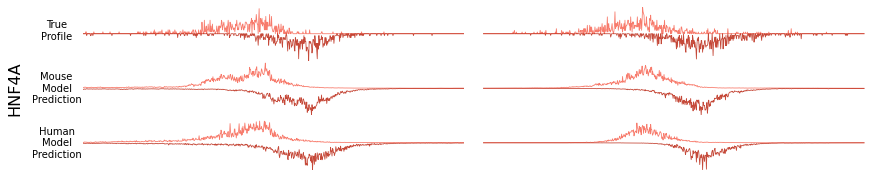

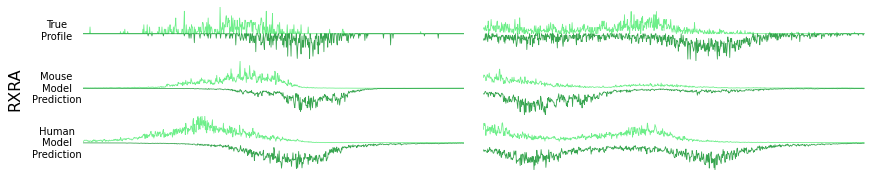

In [16]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_profiles_across_species_tfs(save = True)